# European Multi-Country & Cross-Border TD-OPF Analysis

This notebook compares Temperature-Dependent OPF results across
multiple European countries, including cross-border interconnection
effects.

**Contents**
1. Imports & configuration
2. Cross-border data loading utility
3. Spain-based cross-border analysis (ES↔FR, ES↔PT)
4. France-based cross-border analysis (FR↔IT, FR↔ES, FR↔GB)
5. Multi-country separate analysis (8 countries)
6. Multi-country summary plots

## 1. Imports & Configuration

In [1]:
import os
import sys
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

cur_dir = os.path.dirname(os.path.abspath(os.getcwd()))
sys.path.append(os.path.join(os.getcwd(), ".."))

from data_config import *
from utils.network_process_utils import *
from utils.plot_utils import *

## 2. Cross-Border Data Loading

`get_cross_border_data` loads single-country and cross-border OPF
results, computing per-scenario load shedding (restricted to the
primary country's buses), line temperature, and capacity drop.

In [2]:
def get_cross_border_data(primary_country, country_pairs, networks,
                         storage_state, load_rate, TDPF_solver):
    """Collect load-shedding, temperature, and capacity-drop data
    for a primary country and its cross-border interconnections.

    Parameters
    ----------
    primary_country : str
        Two-letter country code for the focal country.
    country_pairs : list[list[str]]
        Each element is a two-country list, e.g. ``['ES', 'FR']``.
    networks : dict[tuple, pypsa.Network]
        Pre-loaded cross-border networks keyed by ``tuple(pair)``.
    storage_state : float
        Battery state-of-charge parameter.
    load_rate : float
        Annual load-growth rate (e.g. 1.03 for 3 %).
    TDPF_solver : str
        Solver/analysis-method identifier.

    Returns
    -------
    tuple
        ``(load_shedding_list, line_temp_list, line_capacity_drop_list)``
        — each is a list of arrays: first element is the single-country
        result, followed by one element per cross-border pair.
    """
    # --- Build valid-index across all cross-border pairs ------------------
    valid_index_list = []
    for pair in country_pairs:
        n_bus = networks[tuple(pair)].buses.shape[0]
        csv_path = (
            cur_dir
            + f'/models/{list(pair)}/{list(pair)}_{n_bus}_bus'
            + f'_renewable_True_heatwave_True_storage_True_{storage_state}'
            + f'_load_growth_True_{load_rate}_max_temp_90'
            + f'_sensitivity_analysis.csv'
        )
        df = pd.read_csv(csv_path)
        sub_df = df[df['TDPF_solver'] == TDPF_solver]
        valid_index_list.append(sub_df['solver_status'] == 1)
    valid_index_list = np.stack(valid_index_list, axis=0)
    valid_index = np.logical_and.reduce(valid_index_list, axis=0)

    # --- Precompute bus / line masks for each cross-border network --------
    indices = {}
    for pair, net in networks.items():
        ref_country = pair[0]
        bus_ref = net.buses.country == ref_country
        line_ref = (
            (net.buses.loc[net.lines.bus1].country.values == ref_country)
            & (net.buses.loc[net.lines.bus0].country.values == ref_country)
        )
        indices[pair] = (bus_ref, line_ref)

    # --- Result containers ------------------------------------------------
    load_shedding_sep = []
    line_temp_sep = []
    line_capa_sep = []

    load_shedding_joint = {pair: [] for pair in networks}
    line_temp_joint = {pair: [] for pair in networks}
    line_capa_joint = {pair: [] for pair in networks}

    # --- Iterate over valid scenarios -------------------------------------
    for fut_date in sub_df.loc[valid_index, 'fut_heatwave_date'].unique():
        sub2 = sub_df[sub_df['fut_heatwave_date'] == fut_date]
        for his_date in sub2['his_heatwave_date'].unique():
            his_fmt = datetime.strptime(
                his_date, '%Y-%m-%d'
            ).strftime('%Y-%m-%d %H:%M:%S')

            # Single-country result
            n_bus = country_bus[primary_country]
            base_id = (
                f'{primary_country}_{n_bus}_{TDPF_solver}'
                f'_{fut_date}_{his_fmt}'
            )
            para_id = f'storage_{storage_state}_load_growth_{load_rate}_thermal_90'
            ppc_path = cur_dir + f'/models/{primary_country}/ppc/{fut_date}'
            results = np.load(
                os.path.join(ppc_path, f'{base_id}_{para_id}_results.npy'),
                allow_pickle=True,
            ).item()

            single_LD = results['PD'].sum()
            if results['solver_status'] == 1:
                load_shedding_sep.append(
                    results['LS'].sum() / single_LD * 100
                )
                line_temp_sep.append(results['con_temp'].max(1))
                line_capa_sep.append(results['capacity_drop'] * 100)

            # Cross-border results
            for pair, net in networks.items():
                n_bus = net.buses.shape[0]
                base_id = (
                    f'{list(pair)}_{n_bus}_{TDPF_solver}'
                    f'_{fut_date}_{his_fmt}'
                )
                ppc_path = cur_dir + f'/models/{list(pair)}/ppc/{fut_date}'
                results = np.load(
                    os.path.join(ppc_path, f'{base_id}_{para_id}_results.npy'),
                    allow_pickle=True,
                ).item()
                bus_ref, line_ref = indices[pair]
                load_shedding_joint[pair].append(
                    results['LS'][bus_ref].sum() / single_LD * 100
                )
                line_temp_joint[pair].append(
                    results['con_temp'].max(1)[line_ref]
                )
                line_capa_joint[pair].append(
                    results['capacity_drop'] * 100
                )

    # --- Assemble output lists (single-country first, then pairs) ---------
    ls_all = ([np.array(load_shedding_sep)]
              + [np.array(load_shedding_joint[tuple(p)]) for p in country_pairs])
    temp_all = ([np.concatenate(line_temp_sep)]
                + [np.concatenate(line_temp_joint[tuple(p)]) for p in country_pairs])
    capa_all = ([np.concatenate(line_capa_sep)]
                + [np.concatenate(line_capa_joint[tuple(p)]) for p in country_pairs])

    return ls_all, temp_all, capa_all

## 3. Spain-Based Cross-Border Analysis

Loading EU network from: /Users/liangenming/Desktop/Code/Power-System-Evaluation/HeatAnalysis/data/EU/networks/base_s_75_elec.nc


INFO:pypsa.io:Imported network base_s_75_elec.nc has buses, carriers, generators, lines, links, loads, storage_units, stores


Loading EU network from: /Users/liangenming/Desktop/Code/Power-System-Evaluation/HeatAnalysis/data/EU/networks/base_s_75_elec.nc


INFO:pypsa.io:Imported network base_s_75_elec.nc has buses, carriers, generators, lines, links, loads, storage_units, stores


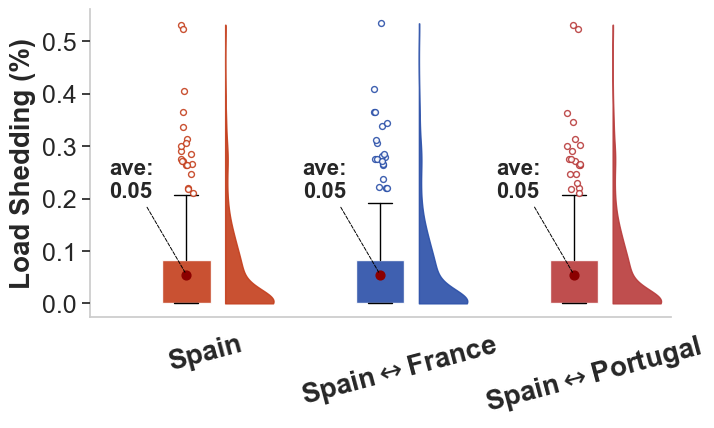

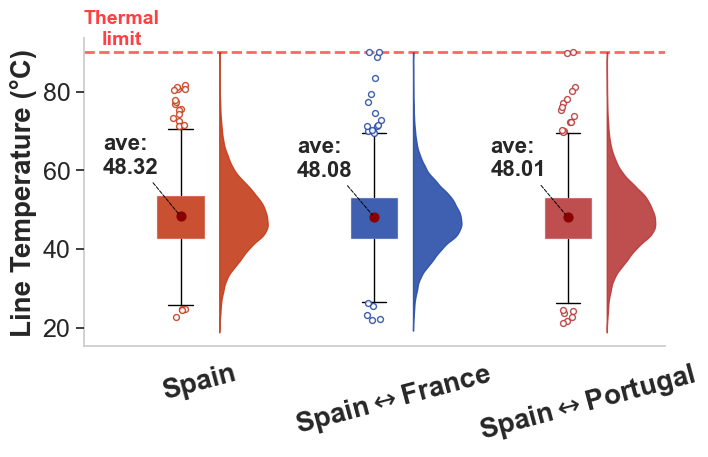

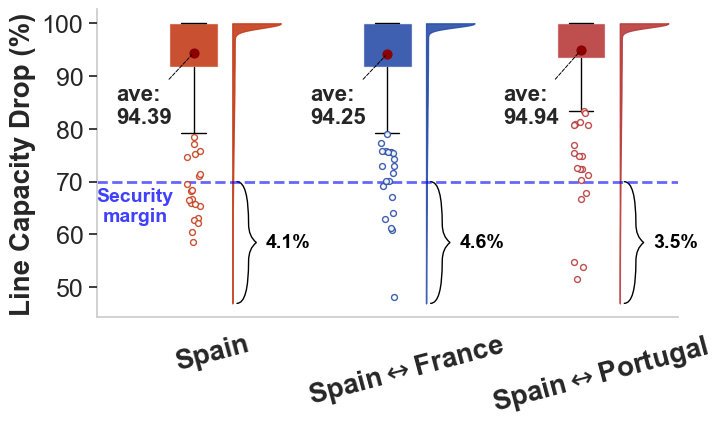

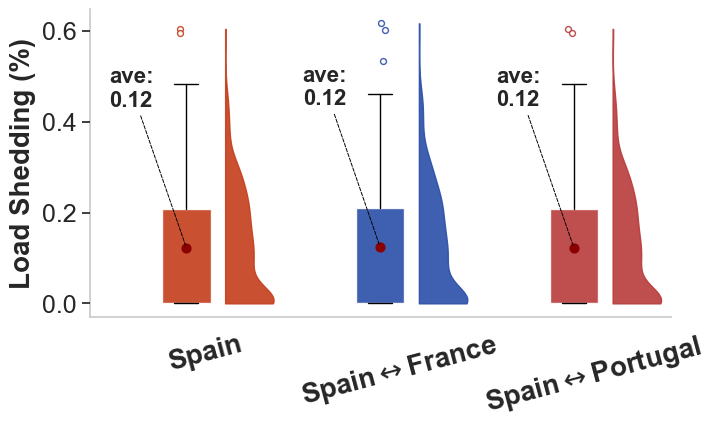

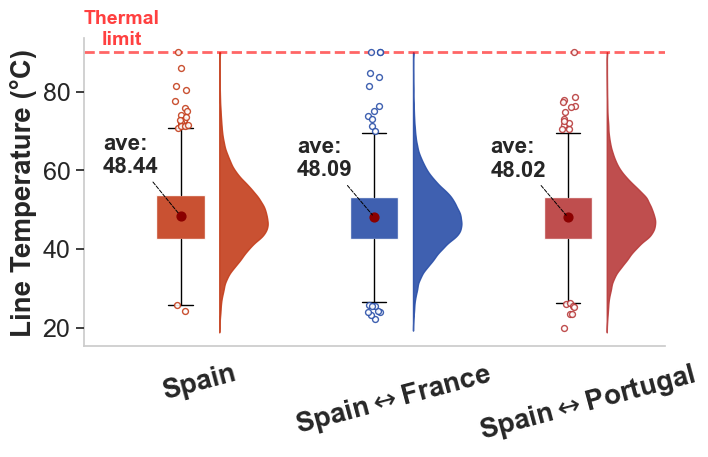

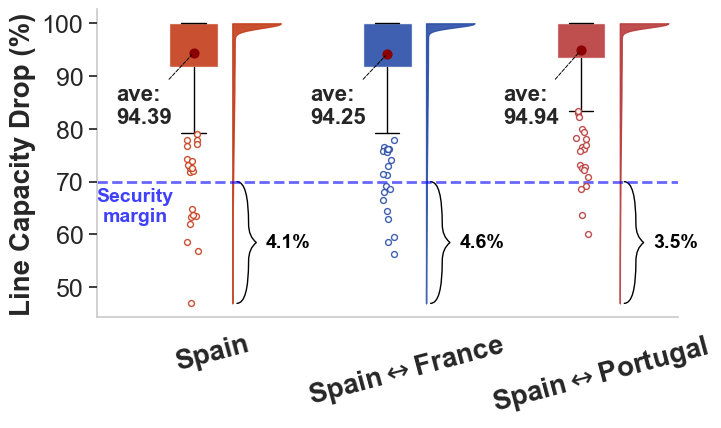

In [3]:
primary_country = 'ES'
country_pairs = [['ES', 'FR'], ['ES', 'PT']]
networks = {
    tuple(pair): load_network_EU(pair, RATIO)[0]
    for pair in country_pairs
}

TDPF_solver = 'td_seg_derate_iter_2'

for load_rate in [1.01,1.03]:
# load_rate = 1.01
    storage_state = 0.8

    load_shedding_list, line_temp_list, line_capa_list = get_cross_border_data(
        primary_country, country_pairs, networks,
        storage_state, load_rate, TDPF_solver,
    )

    save_dir = MODELS + '/ES/pics/cross_border_analysis'
    os.makedirs(save_dir, exist_ok=True)

    country_list = [
        'Spain',
        r'Spain$\leftrightarrow$France',
        r'Spain$\leftrightarrow$Portugal',
    ]
    colors = ['#C43E1C', '#2A4FA8', '#B83B3B']

    box_violin_plot(
        load_shedding_list, country_list, colors, 'Load Shedding (%)',
        os.path.join(save_dir,
                    f'model_cross_border_load_shedding_box_violin.pdf_{load_rate}_{storage_state}.pdf'),
        label_rotation=15,
    )
    box_violin_plot(
        line_temp_list, country_list, colors, 'Line Temperature (°C)',
        os.path.join(save_dir,
                    f'model_cross_border_line_temp_box_violin.pdf_{load_rate}_{storage_state}.pdf'),
        label_rotation=15, threshold=90, exceed_direction='above',
    )
    box_violin_plot(
        line_capa_list, country_list, colors, 'Line Capacity Drop (%)',
        os.path.join(save_dir,
                    f'model_cross_border_line_capacity_drop_box_violin.pdf_{load_rate}_{storage_state}.pdf'),
        label_rotation=15, threshold=70, exceed_direction='below',
    )

## 4. France-Based Cross-Border Analysis

Loading EU network from: /Users/liangenming/Desktop/Code/Power-System-Evaluation/HeatAnalysis/data/EU/networks/base_s_75_elec.nc


INFO:pypsa.io:Imported network base_s_75_elec.nc has buses, carriers, generators, lines, links, loads, storage_units, stores


Loading EU network from: /Users/liangenming/Desktop/Code/Power-System-Evaluation/HeatAnalysis/data/EU/networks/base_s_75_elec.nc


INFO:pypsa.io:Imported network base_s_75_elec.nc has buses, carriers, generators, lines, links, loads, storage_units, stores


Loading EU network from: /Users/liangenming/Desktop/Code/Power-System-Evaluation/HeatAnalysis/data/EU/networks/base_s_75_elec.nc


INFO:pypsa.io:Imported network base_s_75_elec.nc has buses, carriers, generators, lines, links, loads, storage_units, stores


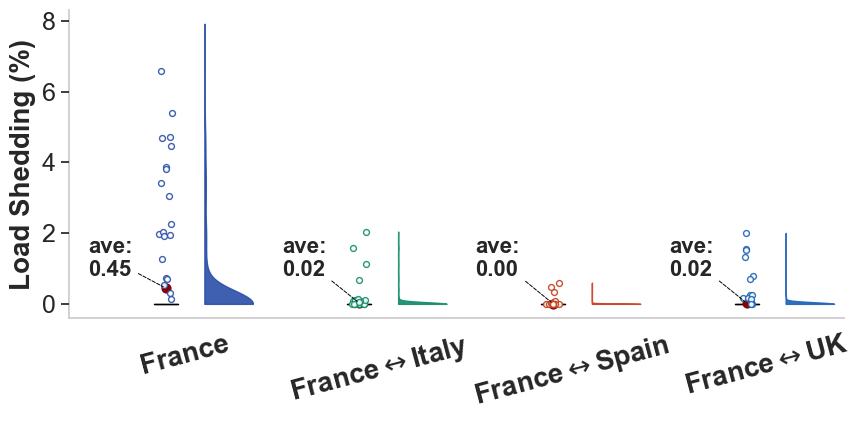

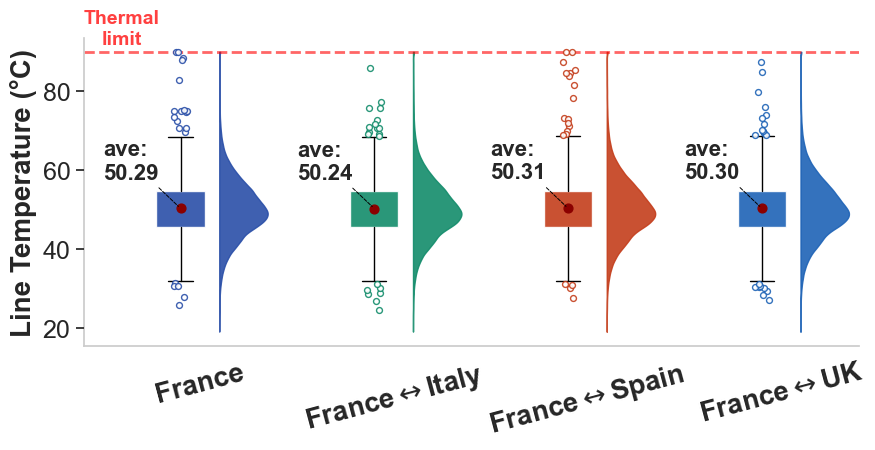

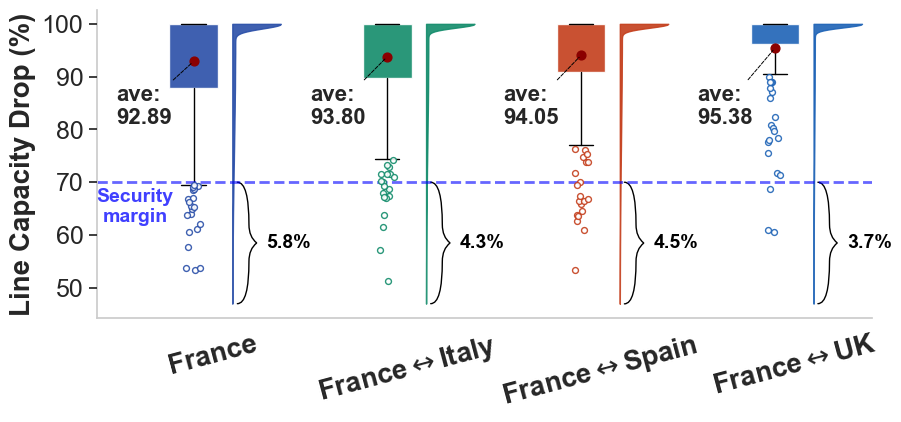

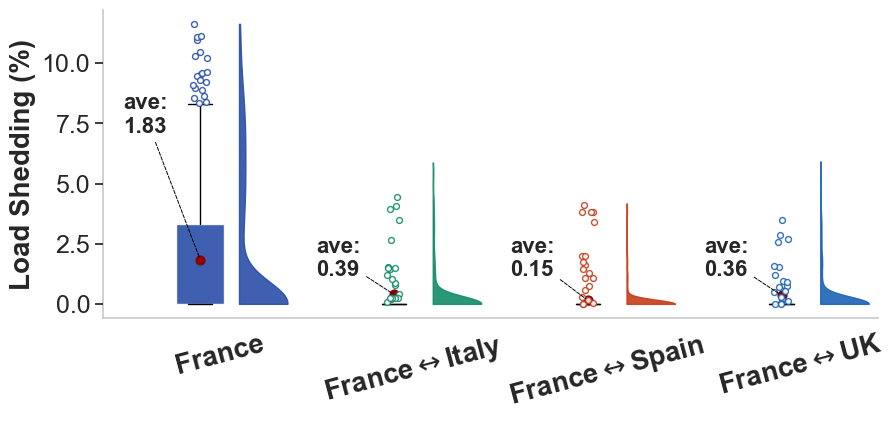

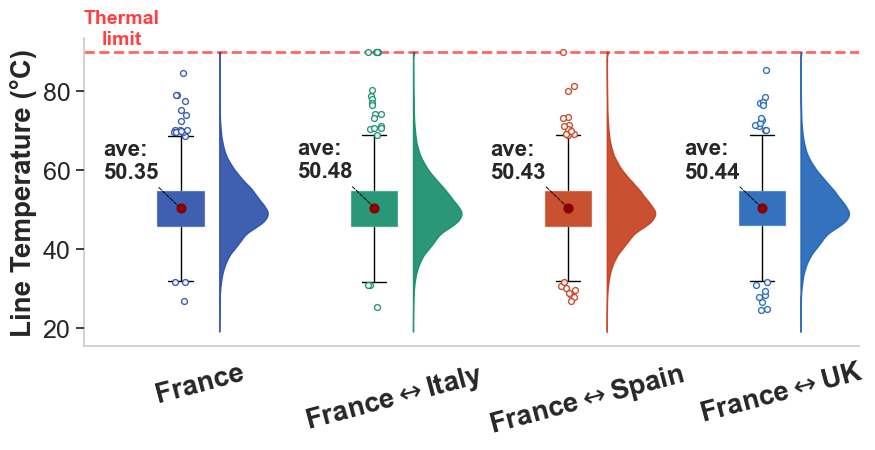

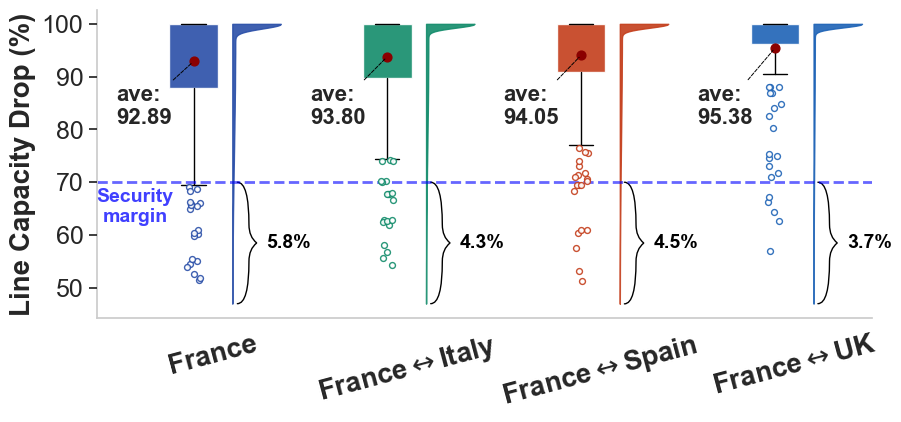

In [4]:
primary_country = 'FR'
country_pairs = [['FR', 'IT'], ['FR', 'ES'], ['FR', 'GB']]
networks = {
    tuple(pair): load_network_EU(pair, RATIO)[0]
    for pair in country_pairs
}

TDPF_solver = 'td_seg_derate_iter_2'

for load_rate in [1.01,1.03]:

    # load_rate = 1.01
    storage_state = 0.8

    load_shedding_list, line_temp_list, line_capa_list = get_cross_border_data(
        primary_country, country_pairs, networks,
        storage_state, load_rate, TDPF_solver,
    )

    save_dir = MODELS + '/FR/pics/cross_border_analysis'
    os.makedirs(save_dir, exist_ok=True)

    country_list = [
        'France',
        r'France$\leftrightarrow$Italy',
        r'France$\leftrightarrow$Spain',
        r'France$\leftrightarrow$UK',
    ]
    colors = ['#2A4FA8', '#138C6B', '#C43E1C', '#1E63B6']

    box_violin_plot(
        load_shedding_list, country_list, colors, 'Load Shedding (%)',
        os.path.join(save_dir,
                    f'model_cross_border_load_shedding_box_violin.pdf_{load_rate}_{storage_state}.pdf'),
        label_rotation=15,
    )
    box_violin_plot(
        line_temp_list, country_list, colors, 'Line Temperature (°C)',
        os.path.join(save_dir,
                    f'model_cross_border_line_temp_box_violin.pdf_{load_rate}_{storage_state}.pdf'),
        label_rotation=15, threshold=90, exceed_direction='above',
    )
    box_violin_plot(
        line_capa_list, country_list, colors, 'Line Capacity Drop (%)',
        os.path.join(save_dir,
                    f'model_cross_border_line_capacity_drop_box_violin.pdf_{load_rate}_{storage_state}.pdf'),
        label_rotation=15, threshold=70, exceed_direction='below',
    )

## 5. Multi-Country Separate Analysis

Compare TD-OPF results independently for each of eight European
countries under the same heatwave-projection scenario.

In [5]:
def get_country_data(load_rate, storage_state, country_code, n_bus, analysis_list):
    """Load summary metrics and per-branch results for one country.

    Returns
    -------
    tuple
        ``(load_shedding, air_temp, capacity_drop, line_temp,
          run_time, load)`` — each a list of arrays (one per solver
        in ``analysis_list``).
    """
    csv_path = (
        cur_dir
        + f'/models/{country_code}/{country_code}_{n_bus}_bus'
        + f'_renewable_True_heatwave_True_storage_True_{storage_state}'
        + f'_load_growth_True_{load_rate}_max_temp_90_model_analysis.csv'
    )
    df = pd.read_csv(csv_path)

    # Valid-index across all solvers
    # vi_masks = []
    # for solver in analysis_list:
    #     sub = df[df['TDPF_solver'] == solver]
    #     vi_masks.append((sub['solver_status'] == 1).values)
    # valid_index = np.logical_and.reduce(np.stack(vi_masks))

    # Per-solver summary metrics
    load_shedding_list = []
    air_temp_list = []
    run_time_list = []
    load_list = []

    for solver in analysis_list:
        sub = df[df['TDPF_solver'] == solver]
        valid_index = sub['solver_status'] == 1
        load_shedding_list.append(
            sub.loc[valid_index, 'node_load_shedding'].values.reshape(-1)
        )
        air_temp_list.append(
            sub.loc[valid_index, 'air_temp'].values.reshape(-1)
        )
        run_time_list.append(
            sub.loc[valid_index, 'run_time'].values.reshape(-1)
        )
        load_list.append(
            sub.loc[valid_index, 'load'].values.reshape(-1)
        )

    # Per-branch temperature and capacity drop (last solver in list)
    solver = analysis_list[-1]
    sub = df[df['TDPF_solver'] == solver]
    line_temp_list = []
    line_capa_list = []
    for fut_date in sub.loc[valid_index, 'fut_heatwave_date'].unique():
        sub2 = sub[sub['fut_heatwave_date'] == fut_date]
        ppc_path = cur_dir + f'/models/{country_code}/ppc/{fut_date}'
        for his_date in sub2['his_heatwave_date'].unique():
            his_fmt = datetime.strptime(
                his_date, '%Y-%m-%d'
            ).strftime('%Y-%m-%d %H:%M:%S')
            fname = (
                f'{country_code}_{n_bus}_{solver}_{fut_date}_{his_fmt}'
                f'_storage_{storage_state}_load_growth_{load_rate}'
                f'_thermal_90_results.npy'
            )
            results = np.load(
                os.path.join(ppc_path, fname), allow_pickle=True
            ).item()
            line_temp_list.append(results['con_temp'].max(1))
            line_capa_list.append(results['capacity_drop'] * 100)

    line_temp_list = [np.concatenate(line_temp_list).reshape(-1)]
    line_capa_list = [np.concatenate(line_capa_list).reshape(-1)]

    return (load_shedding_list, air_temp_list, line_capa_list,
            line_temp_list, run_time_list, load_list)

In [6]:
analysis_list = ['td_seg_derate_iter_2']
country_code_list = ['PT', 'NL', 'BE', 'GB', 'DE', 'ES', 'IT', 'FR']
load_rate = 1.01
storage_state = 0.8

line_temp_all = []
air_temp_all = []
load_shedding_all = []
capa_drop_all = []
run_time_all = []
load_all = []

for cc in country_code_list:
    n_bus = country_bus[cc]
    (ls, at, capa, lt, rt, ld) = get_country_data(
        load_rate, storage_state, cc, n_bus,analysis_list
    )
    line_temp_all.append(np.array(lt).reshape(-1))
    air_temp_all.append(np.array(at).reshape(-1))
    load_shedding_all.append(np.array(ls).reshape(-1))
    capa_drop_all.append(np.array(capa).reshape(-1))
    run_time_all.append(np.array(rt).reshape(-1))
    load_all.append(np.array(ld).reshape(-1))

In [7]:
load_shedding_all[-1].std()

1.2725446052971927

## 6. Multi-Country Summary Plots

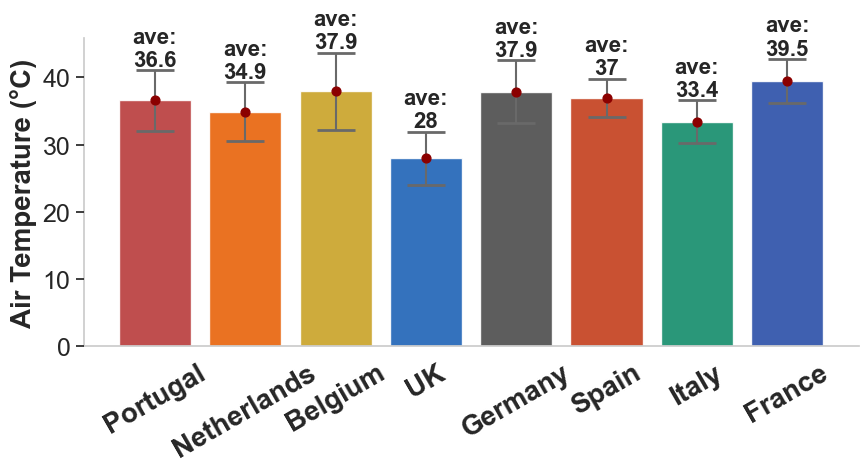

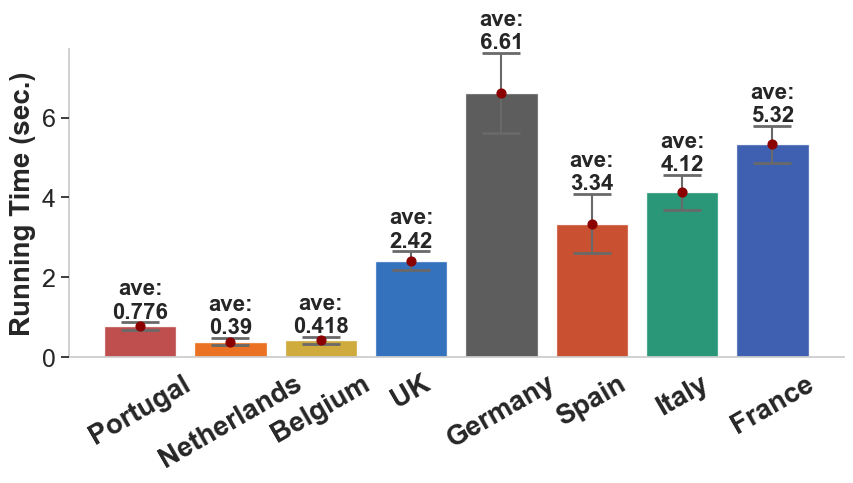

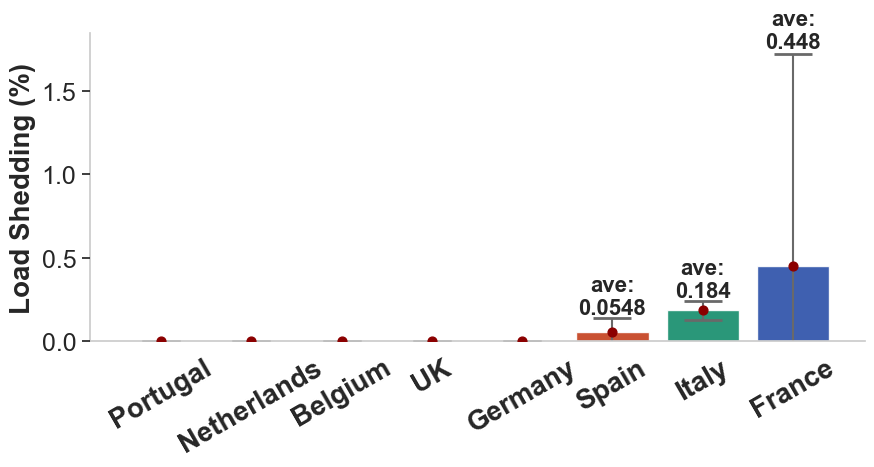

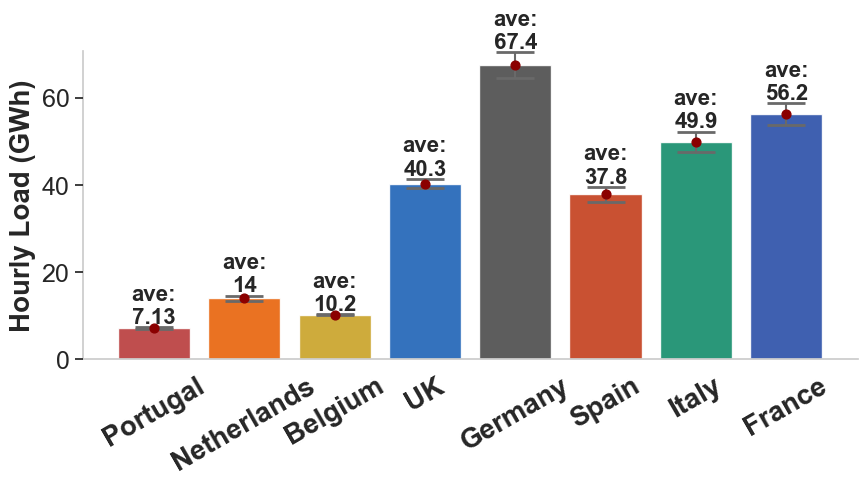

In [8]:
country = [country_name[k] for k in country_code_list]
country_color = [country_color_list[k] for k in country_code_list]
mc_dir = os.path.join(cur_dir, 'models/multi_country')

single_bar_plot(
    air_temp_all, country, country_color, 'Air Temperature (°C)',
    os.path.join(mc_dir, 'multi_country_analysis_air_temp.pdf'),
    ratio=1.5, label_rotation=30,
)
single_bar_plot(
    run_time_all, country, country_color, 'Running Time (sec.)',
    os.path.join(mc_dir, 'multi_country_analysis_run_time.pdf'),
    ratio=1.5, label_rotation=30,
)
single_bar_plot(
    load_shedding_all, country, country_color, 'Load Shedding (%)',
    os.path.join(mc_dir, 'multi_country_analysis_load_shedding.pdf'),
    ratio=1.5, label_rotation=30,  
)
single_bar_plot(
    load_all, country, country_color, 'Hourly Load (GWh)',
    os.path.join(mc_dir, 'multi_country_analysis_load.pdf'),
    ratio=1.5, label_rotation=30,
)

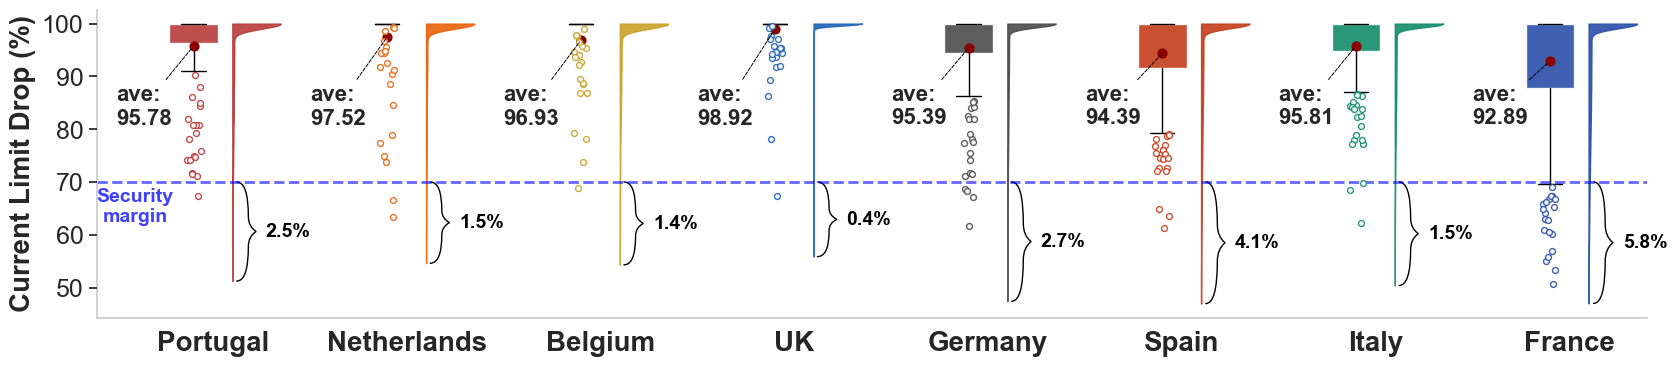

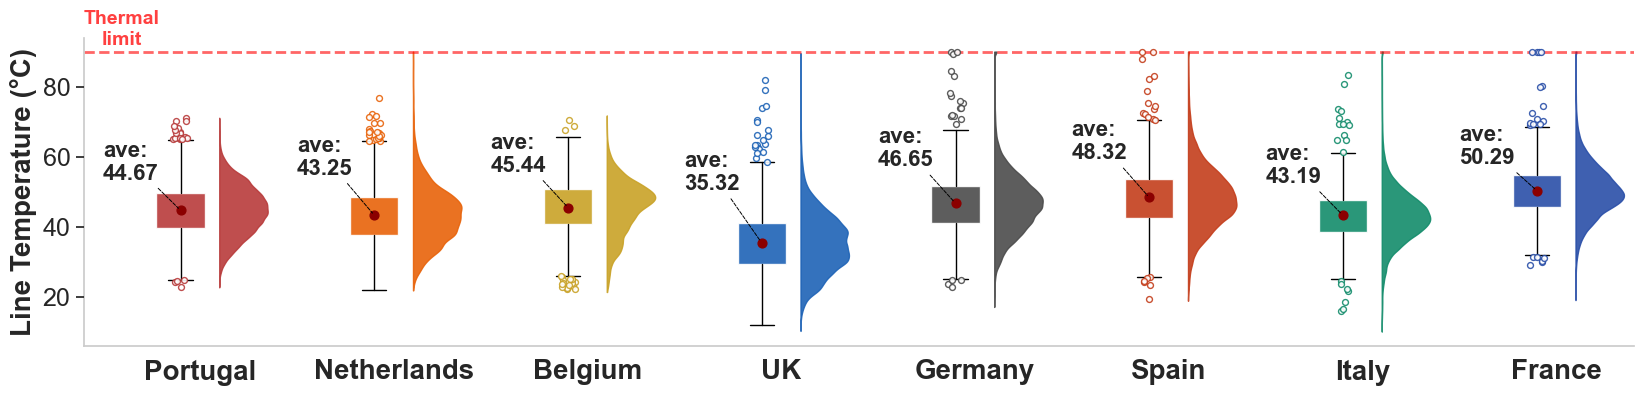

In [9]:
box_violin_plot(
    capa_drop_all, country, country_color, 'Current Limit Drop (%)',
    os.path.join(mc_dir, 'multi_country_analysis_capa_drop.pdf'),
    ratio=2.5, threshold=70, exceed_direction='below',
)
box_violin_plot(
    line_temp_all, country, country_color, 'Line Temperature (°C)',
    os.path.join(mc_dir, 'multi_country_analysis_line_temp.pdf'),
    ratio=2.5, threshold=90, exceed_direction='above',
)